# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 05. GAN для вращения бананов`

#### Фамилия, имя: Булкин Антон

#### `Москва, 2025`

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install omegaconf

In [ ]:
!pip install scikit-video

In [ ]:
!gdown "https://docs.google.com/uc?export=download&id=10879jkDPpi9VxhL4iEA4kbej-H2QfNPM" -O utils_3d.py

Downloading...
From (original): https://docs.google.com/uc?export=download&id=10879jkDPpi9VxhL4iEA4kbej-H2QfNPM
From (redirected): https://docs.google.com/uc?export=download&id=10879jkDPpi9VxhL4iEA4kbej-H2QfNPM&confirm=t&uuid=03d7aba1-4ec2-46ca-b3c5-d77e0d722161
To: D:\utils_3d.py

  0%|          | 0.00/8.72k [00:00<?, ?B/s]
100%|##########| 8.72k/8.72k [00:00<?, ?B/s]


In [ ]:
import os
import math
import copy
import random
from itertools import product
from typing import Optional, Tuple, Union, List

import glob
import regex

import scipy
import numpy as np

import PIL
import PIL.Image

import skvideo.io

import matplotlib_inline
import matplotlib.pyplot as plt
from ipywidgets import Video, GridspecLayout

import wandb
import tqdm.autonotebook as tqdm
from omegaconf import OmegaConf, DictConfig

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim.swa_utils import AveragedModel

try:
    # Работает с torch>=2.2:
    from torch.optim.swa_utils import get_ema_multi_avg_fn
except ImportError:
    PARAM_LIST = Union[Tuple[torch.Tensor, ...], List[torch.Tensor]]

    def get_ema_multi_avg_fn(decay=0.999):
        @torch.no_grad()
        def ema_update(ema_param_list: PARAM_LIST, current_param_list: PARAM_LIST, _):
            # foreach lerp only handles float and complex
            if torch.is_floating_point(ema_param_list[0]) or torch.is_complex(
                ema_param_list[0]
            ):
                # noinspection PyProtectedMember
                torch._foreach_lerp_(ema_param_list, current_param_list, 1 - decay)
            else:
                for p_ema, p_model in zip(ema_param_list, current_param_list):
                    p_ema.copy_(p_ema * decay + p_model * (1 - decay))

        return ema_update

import torchvision.transforms.functional
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from utils_3d import fancy_integration, get_initial_rays_trig, transform_sampled_points, sample_pdf

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

C:\Users\bulki\AppData\Local\Temp\ipykernel_1668\3466698095.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [ ]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())

    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())

def hide_specs(module: torch.nn.Module) -> str:
    """Remove hyperparameters for model __repr__
    :param torch.nn.Module module: Target model
    :return: Cleaned up repr
    :rtype: str
    """
    module_repr = str(module)

    for spec in regex.findall("\(.*\): (.*)", module_repr):
        module_repr = module_repr.replace(spec, regex.sub('\(.*\)', '(...)', spec))

    return module_repr

## `Гиперпараметры`

In [ ]:
from pathlib import Path

In [ ]:
config = OmegaConf.create()

DEST_ROOT = Path("dataset_banana_one")

# Путь к данным
config.template = str(Path("dataset_banana_one") / "*.png")

# Параметры модели
config.z_dim = 224
config.hidden_dim = 224
config.n_blocks = 8

# Параметры для обучения GAN
config.r1_lambda = 5
config.ema_rate = 0.999

# Параметры оптимизатора
config.betas = (0, 0.9)
config.weight_decay = 0
config.grad_clip = 1.0

# Расписание обучения
config.train_config = [
    (0,          {'batch_size': 10, 'img_size': 28, 'gen_lr': 6e-5, 'disc_lr': 2e-4}),
    (25000,     {'batch_size': 6, 'img_size': 56, 'gen_lr': 3e-5, 'disc_lr': 1e-4})
]

# Гиперпарметры для 3D рендеринга и численного интегрирования
config.fov = 30
config.ray_start = 0.7
config.ray_end = 1.3
config.fade_steps = 10_000

config.h_stddev =  math.pi
config.v_stddev = math.pi / 4 * 85 / 90

config.v_mean =  math.pi / 4 * 85 / 90
config.h_mean = math.pi / 2

config.num_steps = 12

# Визуализация
config.img_size_vis = 224

In [ ]:
def extract_training_config(current_step: int, config: DictConfig) -> Tuple[int, DictConfig]:
    """Helper function to retrieve training params for the current step from a config
    :param int current_step:
    :param DictConfig config:
    :rtype: Tuple[int, DictConfig]
    """
    for start_step, train_config in config.train_config[::-1]:
        if start_step <= current_step:
            return start_step, train_config

    raise TypeError('current_step is invalid')

# `Загрузка и предобработка данных`

Изображения взяты из датасета Banana Ripeness Images Datasets (https://data.mendeley.com/datasets/66kjghpjgy/1#:~:text=Dataset, https://github.com/luischuquim/BananaRipeness).

Использовалась часть Synthetic и выборки из изображений только 1 банана (с различными Ripeness)

После скачивания изображения были преобразованы в размер 224x224, а также произведена обработка с целью оставить только изображения банана и белый фон:

```python
import random
from pathlib import Path
from io import BytesIO
from tqdm import tqdm
import os
from PIL import Image
from rembg import remove
import cv2
import numpy as np

SRC_DIR = Path("parce")
DST_DIR = Path("dataset_banana_one")
DST_DIR.mkdir(exist_ok=True

def postprocess_mask(mask, k=5):  #Убираем мелкие дефекты
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.medianBlur(mask, 3)
    return mask

all_images = list(SRC_DIR.rglob('*.[jp][pn]g'))

random.seed(42)
sampled = random.sample(all_images, 18000)

for img_path in tqdm(sampled, desc="Processing 9500 samples"):
    out_path = DST_DIR / img_path.name
    with img_path.open("rb") as f:
        rgba_bytes = remove(f.read())
    img_rgba = Image.open(BytesIO(rgba_bytes)).convert("RGBA")

    alpha = np.array(img_rgba.split()[-1])
    alpha = postprocess_mask(alpha)
    img_rgba.putalpha(Image.fromarray(alpha))
    white_bg = Image.new("RGBA", img_rgba.size, (255, 255, 255, 255))
    composite = Image.alpha_composite(white_bg, img_rgba).convert("RGB")
    composite.save(out_path, quality=95)
```

После преобразований были вручную отсмотрены и удалены изображения, где осталось что-то кроме бананов

In [ ]:
sorted(os.listdir(str(Path("dataset_banana_one"))))[:5] + sorted(os.listdir(str(Path("dataset_banana_one"))))[-5:], len(os.listdir(str(Path("dataset_banana_one"))))

(['TipoA1_1_Asset_FM_DD0001.png',
  'TipoA1_1_Asset_FM_DD0002.png',
  'TipoA1_1_Asset_FM_DD0003.png',
  'TipoA1_1_Asset_FM_DD0004.png',
  'TipoA1_1_Asset_FM_DD0005.png',
  'Tipo_D_con_manchas_plato_horizontal0432_V_.png',
  'Tipo_D_con_manchas_plato_horizontal0448_V_.png',
  'Tipo_D_con_manchas_plato_horizontal0464_28.png',
  'Tipo_D_con_manchas_plato_horizontal0464_V_.png',
  'Tipo_D_con_manchas_plato_horizontal0480_V_.png'],
 15301)

In [ ]:
from torchvision.transforms.functional import InterpolationMode

In [ ]:
class Carla(Dataset):
    """Carla Dataset"""

    def __init__(self, template: str, img_size: int):
        """
        :param str template: path to the images
        :param int img_size: target image size
        """
        super().__init__()

        self.images_paths = sorted(glob.glob(template))

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ])

    def __len__(self) -> int:
        """
        Number of images
        :rtype: int
        """

        return len(self.images_paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        :param int idx: Image Id
        :return: Image of desired image size
        :rtype: torch.Tensor
        """

        img = PIL.Image.open(self.images_paths[idx]).convert('RGB')
        return self.transform(img)

In [ ]:
def inverse_transform(img_tensor):
    """
    :param torch.Tensor img_tensor: image tensor, shape (3, W, H)
    :return: Image
    :rtype: PIL.Image
    """

    image_np = (img_tensor * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    img      = PIL.Image.fromarray(image_np, 'RGB')
    return img

Проверим датасет и обратное преобразование:

In [ ]:
dataset = Carla(config.template, img_size=64)

dataset_16 = Carla(config.template, img_size=16)

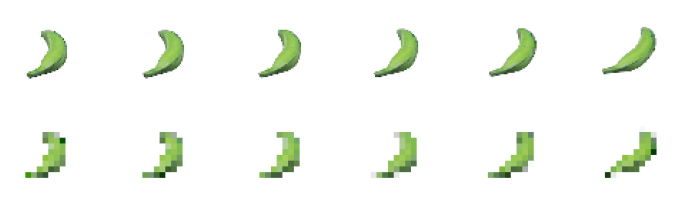

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(10, 3))

for idx, ax in enumerate(axes[0]):
    ax.imshow(inverse_transform(dataset[idx]))

for idx, ax in enumerate(axes[1]):
    ax.imshow(inverse_transform(dataset_16[idx]))

for ax in axes.ravel():
    ax.axis('off')

fig.tight_layout()
plt.show()


Также реализуем вспомогательную функцию, чтобы получать датасет и даталоадер для изображений разного разрешения:

In [ ]:
def get_dataloader(template, img_size: int, batch_size: int, shuffle: bool = True) -> DataLoader:
    """
    :param str template: path to the images
    :param int img_size: target image size
    :param int batch_size: target batch size
    :param bool shuffle: whether to shuffle data in the Dataloader
    :return: Dataloader that encapsulate Dataset with the specified image resolution
    :rtype: DataLoader
    """

    dataset = Carla(template, img_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=0, pin_memory=True)

    return dataloader

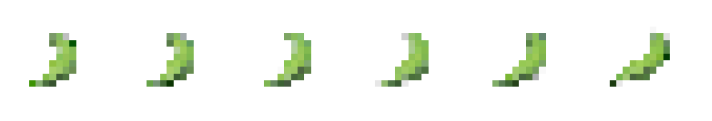

In [ ]:
dataloader = get_dataloader(config.template, img_size=16, batch_size=6, shuffle=False)

images = next(iter(dataloader))

fig, axes = plt.subplots(1, 6, figsize=(10, 3))

for idx, ax in enumerate(axes):
    ax.imshow(inverse_transform(images[idx]))
    ax.axis('off')

fig.tight_layout()
plt.show()

Визуализируем датасет, чтобы понять, как влияет параметр `img_size` на изображения:

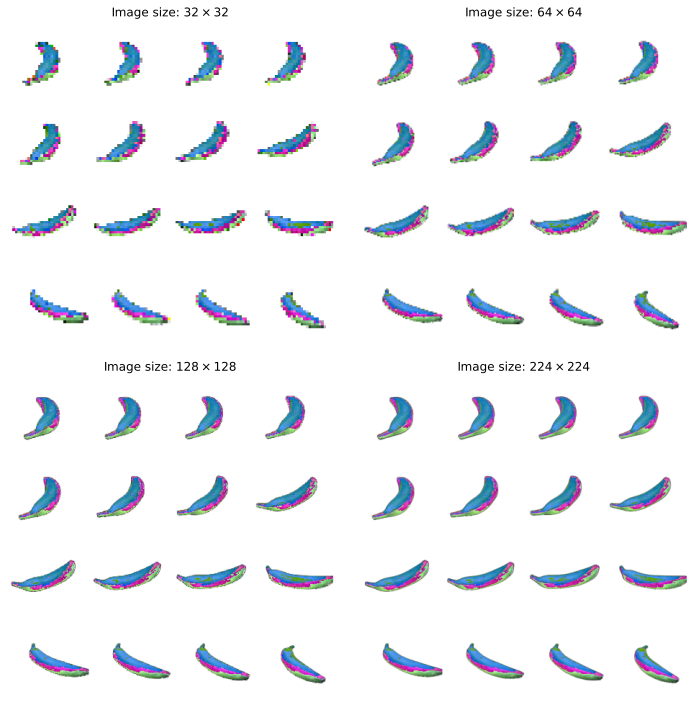

In [ ]:
batch_size = 16
nrow = int(math.sqrt(batch_size))

img_sizes = [32, 64, 128, 224]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for img_size, ax in zip(img_sizes, axes.reshape(-1)):
    dataloader = get_dataloader(config.template, img_size=img_size, batch_size=batch_size, shuffle=False)

    images = next(iter(dataloader))
    images_grid = make_grid(images, nrow, padding=0)
    images_grid = transforms.ToPILImage()(images_grid)

    ax.imshow(images_grid)

    ax.axis('off')
    ax.set_title(fr'Image size: ${img_size} \times {img_size}$')

fig.tight_layout()
plt.show()

# `NeRF`

## `Иницилизация весов`

Инициализация слоёв перед активацией `LeakyReLU`:

In [ ]:
@torch.no_grad()
def kaiming_leaky_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(module.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')

Инициализация первого блока SIREN ($\phi_{0}$):

In [ ]:
@torch.no_grad()
def first_layer_film_sine_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        num_input = module.weight.size(-1)
        h = 1 / num_input
        torch.nn.init.uniform_(module.weight, -h, h)

Инициализация для остальных блоков SIREN ($\phi_{1}, \dots, \phi_{n-1}, \phi_{c}$):

In [ ]:
INIT_FREQ = 25.0

@torch.no_grad()
def frequency_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        num_input = module.weight.size(-1)
        h = np.sqrt(6 / num_input) / INIT_FREQ
        torch.nn.init.uniform_(module.weight, -h, h)

## `Siren`

### `Mapping Network`

In [ ]:
class MappingNetwork(torch.nn.Module):
    def __init__(self, z_dim: int, hidden_dim: int, output_dim: int):
        """
        :param int z_dim: Noise size
        :param int hidden_dim: Hidden dimension for Feed Forward Layers
        :param int output_dim: Output dimension for the module
        """
        super().__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Linear(z_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(hidden_dim, output_dim)
        )

        # Apply weights initialization

        self.network.apply(kaiming_leaky_init)
        with torch.no_grad():
            self.network[-1].weight.mul_(0.25)

    def forward(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param torch.Tensor z: Batch of noise of shape (B, z_dim)
        :return: Tensors with frequencies and phase shifts of shape (B, output_dim // 2)
        """

        x = self.network(z)

        frequencies, phase_shifts = torch.chunk(x, 2, dim=-1)

        return frequencies, phase_shifts

### `FiLM (Feature-wise Linear Modulation)`

In [ ]:
class FiLMLayer(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        :param int in_features: Input dimension
        :param int out_features: Output dimension
        """
        super().__init__()

        self.layer = torch.nn.Linear(in_features, out_features)

    def forward(self, x: torch.Tensor, frequency: torch.Tensor, phase_shift: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x: (B, N, in_features)
        :param torch.Tensor frequency: (B, out_features)
        :param torch.Tensor phase_shift: (B, out_features)
        :return: (B, N, out_features)
        :rtype: torch.Tensor
        """
        # Apply linear layer

        x = self.layer(x)

        # Apply FiLM

        return torch.sin(frequency.unsqueeze(1) * x + phase_shift.unsqueeze(1))

### `SIREN`

In [ ]:
class SIREN(torch.nn.Module):
    """Primary SIREN architecture used in pi-GAN generators."""

    def __init__(self, hidden_dim: int, n_blocks: int):
        """
        :param int hidden_dim: Hidden dimension of FiLM blocks
        :param int n_blocks: Number of FiLM blocks
        """

        super().__init__()

        self.hidden_dim = hidden_dim

        # Create main backbone
        blocks = [FiLMLayer(3, hidden_dim)]
        blocks += [FiLMLayer(hidden_dim, hidden_dim) for _ in range(n_blocks - 1)]
        self.network = torch.nn.ModuleList(blocks)


        # Create sigma head
        self.sigma_head = torch.nn.Linear(hidden_dim, 1)

        # Create FiLM layer for RGB head
        self.rgb_head_film = FiLMLayer(hidden_dim + 3, hidden_dim)

        # Create linear layer for RGB head
        self.rgb_head_linear = torch.nn.Linear(hidden_dim, 3)
        self.sigma = torch.nn.Sigmoid()

        # Apply weights initialization

        self.network[0].layer.apply(first_layer_film_sine_init)
        for i, l in enumerate(self.network[1:]):
            l.apply(frequency_init)
        self.rgb_head_film.apply(frequency_init)
        self.sigma_head.apply(kaiming_leaky_init)
        self.rgb_head_linear.apply(kaiming_leaky_init)


    def forward(
        self, x: torch.Tensor, ray_directions: torch.Tensor,
        frequencies: torch.Tensor, phase_shifts: torch.Tensor
    ) -> torch.Tensor:
        """
        :param torch.Tensor x: 3D points (B, N, 3)
        :param torch.Tensor ray_directions: Ray directions (B, N, 3)
        :param torch.Tensor frequencies: Frequencies to modulate FiLM layers (B, (n_blocks + 1) * hidden_dim)
        :param torch.Tensor phase_shifts: Phase shifts to modulate FiLM layers (B, (n_blocks + 1) * hidden_dim)
        :return: RGB, sigma for each point (B, N, 4)
        :rtype: torch.Tensor
        """
        # Fix view direction on the inference
        if not self.training:
            ray_directions = torch.zeros_like(ray_directions)
            ray_directions[..., -1] = -1

        # Some magic rescaling
        frequencies = frequencies * 15 + 30

        # Apply FiLM layers

        freq_chunks  = torch.split(frequencies, self.hidden_dim, dim=-1)
        phase_chunks = torch.split(phase_shifts, self.hidden_dim, dim=-1)

        for i, layer in enumerate(self.network):
            x = layer(x, freq_chunks[i], phase_chunks[i])

        # Apply sigma head

        sigma = self.sigma_head(x)

        # Apply RGB head

        h_rgb = self.rgb_head_film(torch.cat([x, ray_directions], dim=-1), freq_chunks[-1], phase_chunks[-1])
        rgb = self.rgb_head_linear(h_rgb)
        rgb = self.sigma(rgb)

        return torch.cat([rgb, sigma], dim=-1)

## `Генератор`

In [ ]:
@torch.inference_mode()
def gen_camera_rays_points(
    batch_size: int, img_size: int, num_steps: int, device: torch.device, **kwargs
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate initial points and directions
    :param int batch_size: Target batch size
    :param int img_size: Target image resolution
    :param int num_steps: Number of points selected for each ray direction
    :param torch.device device: Target device
    :param dict kwargs: Hyperparameters to create coarse points
    :return:
        points                  (batch_size, img_size * img_size * num_steps, 3)
        ray_directions_expanded (batch_size, img_size * img_size * num_steps, 3)
        z_vals                  (batch_size, img_size * img_size,  num_steps, 1)
        ray_directions          (batch_size, img_size * img_size,             3)
        ray_origins             (batch_size, img_size * img_size,             3)
    :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
    """
    points_cam, z_vals, rays_d_cam = get_initial_rays_trig(
        batch_size, resolution=(img_size, img_size),  num_steps=num_steps, device=device,
        fov=kwargs['fov'], ray_start=kwargs['ray_start'], ray_end=kwargs['ray_end']
    )

    points, z_vals, ray_directions, ray_origins, _, _ = transform_sampled_points(
        points_cam, z_vals, rays_d_cam, device=device,
        h_stddev=kwargs['h_stddev'], v_stddev=kwargs['v_stddev'],
        h_mean=kwargs['h_mean'], v_mean=kwargs['v_mean']
    )

    ray_directions_expanded = torch.unsqueeze(ray_directions, -2)
    ray_directions_expanded = ray_directions_expanded.expand(-1, -1, num_steps, -1)
    ray_directions_expanded = ray_directions_expanded.reshape(batch_size, img_size * img_size * num_steps, 3)

    points = points.reshape(batch_size, img_size * img_size * num_steps, 3)

    return (
        points, ray_directions_expanded,
        z_vals, ray_directions, ray_origins
    )

@torch.inference_mode()
def gen_fine_points(
    z_vals: torch.Tensor, coarse_output: torch.Tensor, img_size: int, num_steps: int, nerf_noise: float
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Apply importance sampling to obtain "fine" points
    :param torch.Tensor z_vals: Positions of the points on the ray (B, img_size * img_size,  num_steps, 1)
    :param torch.Tensor coarse_output: RGB,sigma for all points    (B, img_size * img_size,  num_steps, 4)
    :param int img_size: Target image resolution
    :param int num_steps: Number of points selected for each ray direction
    :param float nerf_noise: Noise that is used to perturb points during integration
    :return: Refined coarse and fine positions of shape (B, img_size * img_size, num_steps, 1) each
    :rtype: Tuple[torch.Tensor, torch.Tensor]
    """
    batch_size = z_vals.shape[0]

    _, _, weights = fancy_integration(
        coarse_output, z_vals, device=z_vals.device, noise_std=nerf_noise
    )

    weights = weights.reshape(batch_size * img_size * img_size, num_steps)

    # Start new importance sampling
    z_vals = z_vals.reshape(batch_size * img_size * img_size, num_steps)
    z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:])
    z_vals = z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)

    fine_z_vals = sample_pdf(z_vals_mid, weights[:, 1:-1], num_steps, det=False)
    fine_z_vals = fine_z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)

    return z_vals, fine_z_vals

def get_pixels(
    outputs: torch.Tensor, z_vals: torch.Tensor, img_size: int, nerf_noise: float
) -> torch.Tensor:
    """Performs integration to obtain target image
    :param torch.Tensor outputs: RGB,sigma for all points          (B, img_size * img_size,  2 * num_steps, 4)
    :param torch.Tensor z_vals: Positions of the points on the ray (B, img_size * img_size,  2 * num_steps, 1)
    :param int img_size: Target image resolution
    :return: Batch of images [B, 3, img_size, img_size] with pixels in range [-1, 1]
    :rtype: torch.Tensor
    """
    batch_size = z_vals.shape[0]

    _, indices = torch.sort(z_vals, dim=-2)
    z_vals = torch.gather(z_vals, -2, indices)
    outputs = torch.gather(outputs, -2, indices.expand(-1, -1, -1, 4))

    pixels, _, _ = fancy_integration(
        outputs, z_vals, device=z_vals.device, noise_std=nerf_noise
    )

    pixels = pixels.reshape((batch_size, img_size, img_size, 3))
    pixels = pixels.permute(0, 3, 1, 2).contiguous() * 2.0 - 1.0

    return pixels

In [ ]:
class ImplicitGenerator3d(torch.nn.Module):
    def __init__(self, z_dim: int, hidden_dim: int, n_blocks: int = 8):
        """
        :param int z_dim: Noise size
        :param int hidden_dim: Hidden dimension of Linear layers
        :param int n_blocks: Number of FiLM blocks
        """

        super().__init__()

        self.z_dim = z_dim

        # Create mapping network
        self.mapping_network = MappingNetwork(
            z_dim=z_dim,
            hidden_dim=hidden_dim,
            output_dim=2 * (n_blocks + 1) * hidden_dim
        )

        # Create siren
        self.siren = SIREN(hidden_dim=hidden_dim, n_blocks=n_blocks)

    @torch.inference_mode()
    def generate_avg_frequencies(
        self, n: int = 10000, device: torch.device = torch.device('cpu')
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculates average output of mapping network: frequencies and phase shifts
        :param int n: Number of samples to estimate average
        :param torch.device device: Target device
        :return: average frequencies and phase shifts of shape (1, (n_blocks + 1) * hidden_dim)
        :rtype: Tuple[torch.Tensor, torch.Tensor]
        """

        # Sample random noise

        z = torch.randn(n, self.z_dim, device=device)

        # Make forward pass through mapping network

        frequencies, phase_shifts = self.mapping_network(z)

        # Compute average frequencies and phase shifts

        avg_frequencies = frequencies.mean(0, keepdim=True)
        avg_phase_shifts = phase_shifts.mean(0, keepdim=True)

        return avg_frequencies, avg_phase_shifts

    def forward(
        self, z: torch.Tensor, img_size: int, num_steps: int,
        psi: float = 1.0, nerf_noise: float = 0.0, **kwargs
    ) -> torch.Tensor:
        """
        Generates images from a noise vector, rendering parameters, and camera distribution.
        Uses the hierarchical sampling scheme described in NeRF.
        :param torch.Tensor z: Noise tensor of shape (B, z_dim)
        :param int img_size: Target image resolution
        :param int num_steps: Number of points selected for each ray direction
        :param float psi: Magnitude of the truncation trick
        :param float nerf_noise: Noise that is used to perturb points during integration
        :param dict kwargs: Hyperparameters to create coarse points
        :return: (B, 3, img_size, img_size)
        :rtype: torch.Tensor
        """

        batch_size = z.shape[0]
        device = z.device

        # Calculates frequencies and phase shifts

        frequencies, phase_shifts = self.mapping_network(z)

        # Perform truncation trick. Apply it only on inference
        if not self.training:

            avg_frequencies, avg_phase_shifts = self.generate_avg_frequencies(device=device)

            frequencies = avg_frequencies + psi * (frequencies - avg_frequencies)
            phase_shifts = avg_phase_shifts + psi * (phase_shifts - avg_phase_shifts)

        # Get coarse points. Use gen_camera_rays_points

        (points_coarse, raydirs_exp_coarse,
         z_vals, ray_directions, ray_origins) = gen_camera_rays_points(batch_size=batch_size, img_size=img_size,
                                                                       num_steps=num_steps, device=device, **kwargs)

        # Get coarse output using SIREN

        coarse_output = self.siren(points_coarse, raydirs_exp_coarse, frequencies, phase_shifts)\
                                   .view(batch_size, img_size * img_size, num_steps, 4)

        # Get fine points. Use gen_fine_points to obtain target positions on the ray
        #   Then you should compute points using expression (1)

        z_vals_coarse, fine_z_vals = gen_fine_points(z_vals, coarse_output, img_size, num_steps, nerf_noise)
        fine_points = (ray_origins.unsqueeze(-2) + fine_z_vals * ray_directions.unsqueeze(-2))
        fine_points_flat = fine_points.view(batch_size, img_size * img_size * num_steps, 3)
        raydirs_exp_fine = ray_directions.unsqueeze(-2).expand(-1, -1, num_steps, -1).reshape(batch_size,
                                                                                              img_size * img_size * num_steps, 3)

        # Get fine output using SIREN

        fine_output = self.siren(fine_points_flat, raydirs_exp_fine, frequencies, phase_shifts)\
                                 .view(batch_size, img_size * img_size, num_steps, 4)

        # Render final image. Use get_pixels
        #   You should pass coarse and fine points as well their positions on the ray

        pixels = get_pixels(torch.cat([coarse_output, fine_output], dim=2),
                            torch.cat([z_vals_coarse, fine_z_vals], dim=2), img_size, nerf_noise)

        return pixels

# `Блоки дискриминатора`

## `CoordConv Layer`

In [ ]:
class AddCoords(torch.nn.Module):
    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        """Concatenate positional information along channels dimension
        :param torch.Tensor x: (B, C,     H, W)
        :return:               (B, C + 2, H, W)
        :rtype: torch.Tensor
        """

        batch_size, _, x_dim, y_dim = x.size()


        result = torch.cat(
            [
                x,
                torch.linspace(-1.0, 1.0, steps=x_dim, device=x.device).view(1, 1, x_dim, 1).expand(batch_size, 1, x_dim, y_dim),
                torch.linspace(-1.0, 1.0, steps=y_dim, device=x.device).view(1, 1, 1, y_dim).expand(batch_size, 1, x_dim, y_dim)
            ],

            dim=1
        )

        return result

Теперь объединим этот слой со свёрткой:

In [ ]:
class CoordConv(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, **kwargs):
        """
        :param int in_channels: Convolution input channels
        :param int out_channels: Convolution output channels
        :param int kernel_size: Convolution kernel size
        :param dict kwargs: Convolution hyperparameters
        """
        super().__init__()

        self.addcoords = AddCoords()
        self.conv = torch.nn.Conv2d(in_channels + 2, out_channels, kernel_size, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x:
        :return:
        :rtype: torch.Tensor
        """

        x = self.addcoords(x)
        x = self.conv(x)

        return x

## `ResidualCoordConvBlock`

In [ ]:
class ResidualCoordConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        """
        :param int in_channels: Convolution input channels
        :param int out_channels: Convolution output channels
        :param int kernel_size: Convolution kernel size
        """
        super().__init__()

        # Create main branch
        self.network = torch.nn.Sequential(
            CoordConv(in_channels, out_channels, kernel_size, padding='same'),
            torch.nn.LeakyReLU(negative_slope=0.2),
            CoordConv(out_channels, out_channels, kernel_size, padding='same')
        )

        # Create pooling layers
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=2)

        # Create projection layers
        if in_channels != out_channels:
            self.projection = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        else:
            self.projection = torch.nn.Identity()

        # Initialize weights

        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(module.weight, a=0.2, nonlinearity='leaky_relu')
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x:
        :return:
        :rtype: torch.Tensor
        """

        x_copy = x
        y = self.network(x)
        x_pool = self.avg_pool(x_copy)
        y_pool = self.avg_pool(y)
        x_pool = self.projection(x_pool)
        y = (x_pool + y_pool) / math.sqrt(2.0)

        return y

## `AdapterBlock`

In [ ]:
class AdapterBlock(torch.nn.Module):
    def __init__(self, output_channels: int):
        """
        :param int output_channels: Convolution output channels
        """
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, output_channels, kernel_size=1, padding=0),
            torch.nn.LeakyReLU(negative_slope=0.2)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x: Batch of images  (B, 3, H, W)
        :return:               Batch of latents (B, C, H, W)
        :rtype: torch.Tensor
        """


        return self.model(x)

## `Дискриминатор`

In [ ]:
class ProgressiveDiscriminator(torch.nn.Module):
    """
    Progressive-growing discriminator, настроенный так, чтобы
    при любой из 7 «стандартных» высот входа (224→4) использовались
    **все 7 ResidualCoordConv блоков**.  Для train-конфига бананов
    (56 → 112 → 224) это означает:
        224 px  →  применяются 7 блоков
        112 px  →  применяются 6 блоков
         56 px  →  применяются 5 блоков
    """

    def __init__(self):
        super().__init__()

        self.img_size_to_index = {
            224: 0,
            112: 1,
             56: 2,
             28: 3,
             14: 4,
              7: 5,
              4: 6
        }

        self.blocks = torch.nn.ModuleList([
            ResidualCoordConvBlock(32,  64),
            ResidualCoordConvBlock(64, 128),
            ResidualCoordConvBlock(128, 224),
            ResidualCoordConvBlock(224, 400),
            ResidualCoordConvBlock(400, 400),
            ResidualCoordConvBlock(400, 400),
            ResidualCoordConvBlock(400, 400)
        ])

        self.fromRGB = torch.nn.ModuleList([
            AdapterBlock(32),
            AdapterBlock(64),
            AdapterBlock(128),
            AdapterBlock(224),
            AdapterBlock(400),
            AdapterBlock(400),
            AdapterBlock(400),
            AdapterBlock(400)
        ])

        self.final_layer = torch.nn.Conv2d(400, 1, kernel_size=1)
        kaiming_leaky_init(self.final_layer)

    def forward(self, images: torch.Tensor, alpha: float) -> torch.Tensor:
        b, _, h, _ = images.shape
        if h not in self.img_size_to_index:
            raise ValueError(f"Unsupported height {h}. "
                             f"Must be one of {list(self.img_size_to_index)}")

        start_idx = self.img_size_to_index[h]

        x = self.fromRGB[start_idx](images)

        if start_idx < len(self.blocks):
            x_high = self.blocks[start_idx](x)
            next_block = start_idx + 1
        else:
            x_high = x
            next_block = start_idx

        if (start_idx + 1) < len(self.fromRGB):
            images_low = torch.nn.functional.avg_pool2d(images, 2)
            x_low = self.fromRGB[start_idx + 1](images_low)
            x = alpha * x_high + (1.0 - alpha) * x_low
        else:
            x = x_high

        for blk in self.blocks[next_block:]:
            x = blk(x)

        x = self.final_layer(x)
        return x.view(b, 1)

# `Цикл обучения`

## `Вспомогательные функции для логирования`

In [ ]:
@torch.inference_mode()
def gen_imgs_log(config, generator, z, device, name):
    copied_config = copy.deepcopy(config)
    copied_config['img_size'] = config.img_size_vis
    copied_config['h_stddev'] = copied_config['v_stddev'] = 0

    with torch.cuda.amp.autocast():
        gen_imgs = generator(z.to(device), **copied_config)

    save_image(
        gen_imgs[:3], os.path.join(config.output_dir, f'{name}_fixed.png'),
        nrow=5, normalize=True
    )

    copied_config['h_mean'] += 0.5
    with torch.cuda.amp.autocast():
        gen_imgs = generator(z.to(device), **copied_config)

    save_image(
        gen_imgs[:3], os.path.join(config.output_dir, f'{name}_tilted.png'),
        nrow=5, normalize=True
    )

@torch.inference_mode()
def gen_random_imgs_log(config, generator, z, device, name):
    copied_config = copy.deepcopy(config)
    copied_config['img_size'] = config.img_size_vis
    copied_config['h_stddev'] = copied_config['v_stddev'] = 0
    copied_config['psi'] = 0.7

    with torch.cuda.amp.autocast():
        gen_imgs = generator(torch.randn_like(z).to(device),  **copied_config)

    save_image(
        gen_imgs[:3], os.path.join(config.output_dir, f'{name}_random.png'),
        nrow=5, normalize=True
    )

def save_all_models(
    config, ema_generator, generator, discriminator,
    optimizer_G, optimizer_D, scaler, epoch
):
    checkpoint = {
        "ema_generator": ema_generator.state_dict(), "scaler": scaler.state_dict(),
        "generator": generator.state_dict(), "discriminator": discriminator.state_dict(),
        "generator_opt": optimizer_G.state_dict(), "discriminator_opt": optimizer_D.state_dict(),

    }
    torch.save(checkpoint, os.path.join(config.output_dir, f'checkpoint_{epoch}.pth'))

In [ ]:
print(OmegaConf.to_yaml(config, resolve=True))

template: dataset_banana_one\*.png
z_dim: 224
hidden_dim: 224
n_blocks: 8
r1_lambda: 5
ema_rate: 0.999
betas:
- 0
- 0.9
weight_decay: 0
grad_clip: 1.0
train_config:
- - 0
  - batch_size: 10
    img_size: 28
    gen_lr: 6.0e-05
    disc_lr: 0.0002
- - 25000
  - batch_size: 6
    img_size: 56
    gen_lr: 3.0e-05
    disc_lr: 0.0001
fov: 30
ray_start: 0.7
ray_end: 1.3
fade_steps: 10000
h_stddev: 3.141592653589793
v_stddev: 0.7417649320975901
v_mean: 0.7417649320975901
h_mean: 1.5707963267948966
num_steps: 12
img_size_vis: 224



In [ ]:
def train(config, device):
    _, train_config = extract_training_config(0, config)

    # Sample noise that will be used for logging
    fixed_z = torch.randn((3, 224), device='cpu')

    # Create generator

    generator = ImplicitGenerator3d(z_dim=config.z_dim, hidden_dim=config.hidden_dim, n_blocks=config.n_blocks).to(device)

    # Create discriminator
    discriminator = ProgressiveDiscriminator().to(device)

    # Create ema generator
    ema_generator = AveragedModel(generator, multi_avg_fn=get_ema_multi_avg_fn(decay=config.ema_rate))

    # Create optimizer for the generator
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_config.gen_lr,
                                   betas=tuple(float(b) for b in config.betas), weight_decay=config.weight_decay)

    # Create optimizer for the discriminator
    optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=train_config.disc_lr,
                                   betas=tuple(float(b) for b in config.betas), weight_decay=config.weight_decay)

    # Create scaler for the mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # ----------
    #  Training
    # ----------

    api = wandb.Api()
    api.client.execute(
        api.CREATE_PROJECT,
        {
            'entityName': config.wandb.entity,
            'name': config.wandb.project,
            'access': 'USER_READ',
        },
    )

    wandb.init(
        entity=config.wandb.entity,
        project=config.wandb.project,
        save_code=True,
        name=config.wandb.name,
        config=OmegaConf.to_container(config, resolve=True)
    )

    dataloader = None
    interior_step_bar = tqdm.tqdm(dynamic_ncols=True, total=config.n_epochs)

    discriminator.step = 0
    current_config = copy.deepcopy(config)
    while discriminator.step <= config.n_epochs:
        # Get current training config
        step_last_upsample, train_config = extract_training_config(discriminator.step, config)

        # Update learning rates from the training config
        for param_group in optimizer_G.param_groups:
            param_group['lr'] = train_config.gen_lr
        for param_group in optimizer_D.param_groups:
            param_group['lr'] = train_config.disc_lr

        # Get dataloader for the correct image resolution
        if not dataloader or dataloader.batch_size != train_config.batch_size:
            dataloader = get_dataloader(config.template, train_config.img_size, train_config.batch_size)

        for idx, real_images in enumerate(dataloader):
            # Get current training config
            _, train_config = extract_training_config(discriminator.step, config)

            # If we finished training with current batch size start new epoch
            if dataloader.batch_size != train_config.batch_size:
                break

            # Set train mode

            generator.train()
            discriminator.train()


            # Move images to device
            real_images = real_images.to(device)

            # Update image_size, nerf_noise and fade alpha
            current_config.img_size = train_config.img_size
            current_config.nerf_noise = max(0.0, 1.0 - discriminator.step / 5000.0)
            alpha = min(1.0, (discriminator.step - step_last_upsample) / config.fade_steps)

            # TRAIN DISCRIMINATOR
            with torch.cuda.amp.autocast():
                # Generate batch of fake images

                # Compute predictions for the real and fake images
                with torch.inference_mode():

                    # Sample random noise from N(0, I), z ~ N(0, 1)
                    # z.shape[0] = batch_size
                    z_fake = torch.randn(real_images.size(0), config.z_dim, device=device)
                    fake_images = generator(z_fake, **current_config)



                real_images.requires_grad_(True)
                real_preds = discriminator(real_images, alpha)
                fake_preds = discriminator(fake_images, alpha)
                # d_adv = torch.nn.functional.softplus(-real_preds).mean() + torch.nn.functional.softplus(fake_preds).mean()

            # Compute gradients of the discriminator w.r.t. to the input. Use torch.autograd.grad
            # Remember, that with mixed precision training all gradients
            #   are scaled w.r.t. scaler.get_scale(). Use this scale and scaler.scale()
            #   to correctly evaluate penalty

            grad_real = torch.autograd.grad(outputs=scaler.scale(real_preds).sum(), inputs=real_images, create_graph=True)[0]
            grad_real = grad_real / scaler.get_scale()


            with torch.cuda.amp.autocast():
                # Compute gradient penalty

                r1_penalty = grad_real.pow(2).flatten(1).sum(1).mean()


                # Compute discriminator loss

                d_loss = (torch.nn.functional.softplus(-real_preds).mean() + torch.nn.functional.softplus(fake_preds).mean() +
                          config.r1_lambda * r1_penalty)



            # Clear gradients

            optimizer_D.zero_grad()

            # Scale loss and perform backward

            scaler.scale(d_loss).backward()

            # Perform gradient clipping (do not forget to unscale gradients)

            scaler.unscale_(optimizer_D)
            d_grad_norm = torch.nn.utils.clip_grad_norm_(discriminator.parameters(), config.grad_clip)

            # Make step of optimization

            scaler.step(optimizer_D)


            # TRAIN GENERATOR
            # Sample random noise from N(0, I), z ~ N(0, 1)
            # z.shape[0] = batch_size
            z = torch.randn(real_images.size(0), config.z_dim, device=device)


            with torch.cuda.amp.autocast():
                # Generate fake images
                fake_images = generator(z, **current_config)

                # Compute predictions for the fake images
                f_preds = discriminator(fake_images, alpha)

                # Compute generator loss

                g_loss = torch.nn.functional.softplus(-f_preds).mean()


            # Clear gradients

            optimizer_G.zero_grad()

            # Scale loss and perform backward

            scaler.scale(g_loss).backward()

            # Perform gradient clipping (do not forget to unscale gradients)

            scaler.unscale_(optimizer_G)
            g_grad_norm = torch.nn.utils.clip_grad_norm_(generator.parameters(), config.grad_clip)

            # Make step of optimization

            scaler.step(optimizer_G)


            # Update scaler

            #...

            scaler.update()

            # Update EMA generator

            ema_generator.update_parameters(generator)



            interior_step_bar.update(1)
            if idx % 10 == 0:
                wandb.log(
                    {
                        'g_loss': g_loss.item(),
                        'd_loss': d_loss.item(),
                        'scaler': scaler.get_scale(),
                        'g_grad_norm': g_grad_norm.item(),
                        'd_grad_norm': d_grad_norm.item(),

                        'g_lr': train_config.gen_lr,
                        'd_lr': train_config.disc_lr,
                        'image_size': train_config.img_size
                    },
                    step=discriminator.step
                )

            if discriminator.step % config.sample_interval == 0:
                generator.eval()
                ema_generator.eval()
                with torch.inference_mode():
                    with torch.cuda.amp.autocast():

                        gen_imgs_log(
                            current_config, generator=generator,
                            z=fixed_z, device=device, name=f'{discriminator.step}'
                        )
                        gen_imgs_log(
                            current_config, generator=ema_generator,
                            z=fixed_z, device=device, name=f'{discriminator.step}_ema'
                        )

                        gen_random_imgs_log(
                            current_config, generator=generator,
                            z=fixed_z, device=device, name=f'{discriminator.step}'
                        )
                        gen_random_imgs_log(
                            current_config, generator=ema_generator,
                            z=fixed_z, device=device, name=f'{discriminator.step}_ema'
                        )
                torch.cuda.empty_cache()

                wandb.log(
                    {
                        'fixed': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_fixed.png')
                        ),
                        'fixed_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_fixed.png')
                        ),
                        'tilted': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_tilted.png')
                        ),
                        'tilted_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_tilted.png')
                        ),
                        'random': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_random.png')
                        ),
                        'random_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_random.png')
                        )
                    },
                    step=discriminator.step
                )

            if discriminator.step % config.model_save_interval == 0:
                save_all_models(
                    config, ema_generator.module, generator, discriminator,
                    optimizer_G, optimizer_D, scaler, epoch=discriminator.step
                )

            discriminator.step += 1

In [ ]:
os.environ['WANDB_API_KEY'] = 'caa895b0b53363e18e6620bf8bbf6e94c5215671'
os.environ['WANDB_MODE'] = 'online'

In [ ]:
config.n_epochs = 50000
config.output_dir = 'bananas_2'
config.sample_interval = 1000
config.model_save_interval = 1000

config.wandb = {
    'entity': "antoshabulkin04-m-v-lomonosovmoscow-state-university", # Ваш ник,
    'name': f'{config.output_dir}',
    'project': 'mmp_practicum_spring_2024|Task 05|Pi-GAN'
}

print(OmegaConf.to_yaml(config, resolve=True))

os.makedirs(config.output_dir, exist_ok=True)

template: dataset_banana_one\*.png
z_dim: 224
hidden_dim: 224
n_blocks: 8
r1_lambda: 5
ema_rate: 0.999
betas:
- 0
- 0.9
weight_decay: 0
grad_clip: 1.0
train_config:
- - 0
  - batch_size: 10
    img_size: 28
    gen_lr: 6.0e-05
    disc_lr: 0.0002
- - 25000
  - batch_size: 6
    img_size: 56
    gen_lr: 3.0e-05
    disc_lr: 0.0001
fov: 30
ray_start: 0.7
ray_end: 1.3
fade_steps: 10000
h_stddev: 3.141592653589793
v_stddev: 0.7417649320975901
v_mean: 0.7417649320975901
h_mean: 1.5707963267948966
num_steps: 12
img_size_vis: 224
n_epochs: 50000
output_dir: bananas_2
sample_interval: 1000
model_save_interval: 1000
wandb:
  entity: antoshabulkin04-m-v-lomonosovmoscow-state-university
  name: bananas_2
  project: mmp_practicum_spring_2024|Task 05|Pi-GAN



In [ ]:
device = (
    torch.device('cuda')
    if torch.cuda.is_available() else
    torch.device('cpu')
)
device

device(type='cuda')

In [ ]:
set_global_seed(42)

try:
    train(config, device)
except KeyboardInterrupt:
    pass

wandb.finish()

C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2476547307.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
wandb: Currently logged in as: antoshabulkin04 (antoshabulkin04-m-v-lomonosovmoscow-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|                                                                                        | 0/50000 [00:00<…

C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2476547307.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2476547307.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2476547307.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2476547307.py:221: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\bulki\AppData\Local\Temp\ipykernel_10172\2548819683.py:7: FutureWarning: `torch.cuda.amp

d_grad_norm,▁▂▂▄▃▂▂▃▃▂▃▃▁▂▂▃▃▂▃▅█▄▅▃▅▄▆▆▅▇▄▆▅▄▃▅▅▄▅▅
d_loss,▆▇▄▇█▆▅▆▇▆█▆▇▆▆▆█▆▂▂▁▂█▆▆▂▇▄▃▄▄▂▄▃▃▅▂▆▄▄
d_lr,██████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
g_grad_norm,▁▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▂▂▃▂▂▃▃▄▅▅▄▅▆▄▇▆▃█▃▄▃▄
g_loss,▁▂▃▂▁▂▄▂▂▂▂▃▃▂▃▂▂▂▂▃▂▂▂▂▂▃▃▅▄▁▄▃▃▄▃▄▅▂▃█
g_lr,████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
image_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████
scaler,█▄▄▄▄▄▄▂▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_grad_norm,19.73986
d_loss,0.82024
d_lr,0.0001


Теперь попробуем выполнить инференс нашей модели.

Загрузим чекпоинт с `ema` весами модели:

In [ ]:
checkpoint_idx = 50000
checkpoint = torch.load(
    f"./{config.output_dir}/checkpoint_{checkpoint_idx}.pth",
    map_location=torch.device('cpu')
)

ema_generator = ImplicitGenerator3d(z_dim=config.z_dim, hidden_dim=config.hidden_dim, n_blocks=config.n_blocks)
ema_generator.load_state_dict(checkpoint['ema_generator'])
ema_generator.to(device)
ema_generator.eval()

C:\Users\bulki\AppData\Local\Temp\ipykernel_1668\4191320610.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


ImplicitGenerator3d(
  (mapping_network): MappingNetwork(
    (network): Sequential(
      (0): Linear(in_features=224, out_features=224, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=224, out_features=224, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=224, out_features=224, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Linear(in_features=224, out_features=4032, bias=True)
    )
  )
  (siren): SIREN(
    (network): ModuleList(
      (0): FiLMLayer(
        (layer): Linear(in_features=3, out_features=224, bias=True)
      )
      (1-7): 7 x FiLMLayer(
        (layer): Linear(in_features=224, out_features=224, bias=True)
      )
    )
    (sigma_head): Linear(in_features=224, out_features=1, bias=True)
    (rgb_head_film): FiLMLayer(
      (layer): Linear(in_features=227, out_features=224, bias=True)
    )
    (rgb_head_linear): Linear(in_features=224, out_fe

In [ ]:
images = []

for _ in range(25):
    with torch.inference_mode():
        z = torch.randn(1, config.z_dim, device=device)
        image = ema_generator(z, img_size=224, **config).cpu()
    images.append(image)

images = torch.cat(images, dim=0)

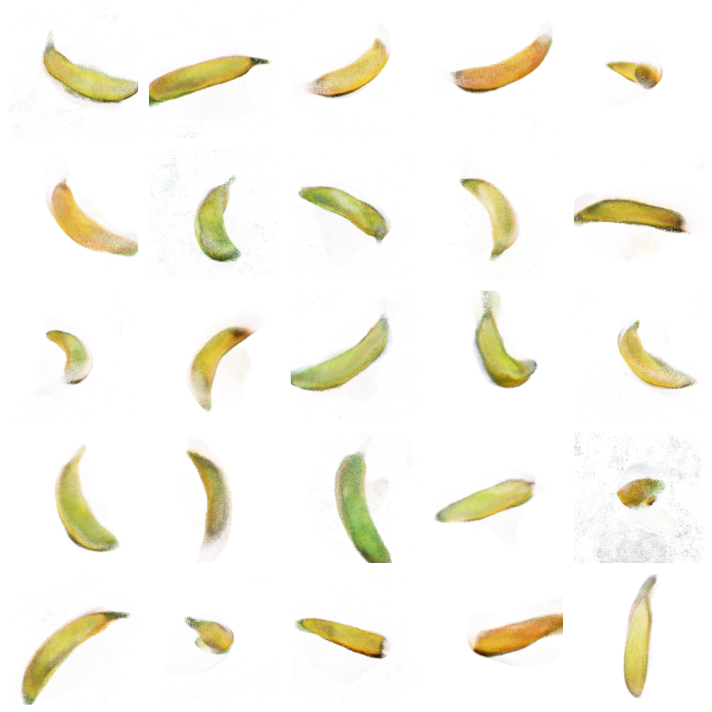

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(inverse_transform(images[idx]))
    ax.axis('off')

fig.tight_layout()
plt.show()

# `Finally, вращаемся`

In [ ]:
video_config = OmegaConf.create(config)

video_config.seeds = list(range(9))
video_config.output_dir = os.path.join(config.output_dir, 'videos')
video_config.image_size = 224
video_config.ray_step_multiplier = 2
video_config.num_frames = 36

video_config.num_steps = config.num_steps * video_config.ray_step_multiplier
video_config.img_size = video_config.image_size
video_config.psi = 0.7
video_config.v_stddev = 0
video_config.h_stddev = 0
video_config.nerf_noise = 0

os.makedirs(video_config.output_dir, exist_ok=True)

Параметры `fov`, `h_mean`, `v_mean` определяют точку, из которой исходит направление взгляда. Создадим список значений параметров, которые соответствуют вращению вокруг объекта:

In [ ]:
trajectory = []
for t in np.linspace(0, 1, video_config.num_frames, dtype=float):
    pitch = math.pi / 4.0
    yaw = 2.0 * math.pi * t
    fov = video_config.fov

    trajectory.append((pitch, yaw, fov))

Теперь для каждого положения сгенерируем изображение с одним и тем же значением шума и объединим полученные изображения в видео:

In [ ]:
for seed in video_config.seeds:
    writer = skvideo.io.FFmpegWriter(
        os.path.join(video_config.output_dir, f'{seed}.mp4'),
        outputdict={'-pix_fmt': 'yuv420p', '-crf': '21'}
    )

    g = torch.Generator(device=device)
    g.manual_seed(seed)
    z = torch.randn(1, config.z_dim, generator=g, device=device)

    frames = []
    with torch.inference_mode():
        for pitch, yaw, fov in tqdm.tqdm(trajectory):
            video_config.h_mean = float(yaw)
            video_config.v_mean = float(pitch)
            video_config.fov = float(fov)
            video_config.h_stddev = 0
            video_config.v_stddev = 0

            frame = ema_generator(z, **video_config)
            frames.append(inverse_transform(frame.squeeze(0)))

        for frame in frames:
            writer.writeFrame(np.array(frame))

        writer.close()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
grid_size = int(np.sqrt(len(video_config.seeds)))
grid = GridspecLayout(grid_size, grid_size)

for seed, (idx, jdx) in zip(video_config.seeds, product(range(grid.n_rows), range(grid.n_columns))):
    grid[idx, jdx] = Video.from_file(
        os.path.join(video_config.output_dir, f'{seed}.mp4'), width=240, height=240
    )

grid

GridspecLayout(children=(Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08fr…

# `FID`

In [ ]:
@torch.inference_mode()
def generate(n, template, generator, transform, batch_size, device):
    os.makedirs(os.path.dirname(template), exist_ok=True)

    generator.to(device)

    n_generated = 0

    pbar = tqdm.tqdm(desc=f'Generate images for the {template}', total=n)
    while n_generated < n:
        z = torch.randn(batch_size, video_config.z_dim, device=device)
        images = generator(z, **video_config).cpu()

        for image in images:
            image = transform(image)
            image.save(template.format(n_generated))

            n_generated += 1
            pbar.update(n=1)

            if n_generated >= n:
                break

In [ ]:
inception_model = torch.hub.load(
    'pytorch/vision:v0.10.0', 'inception_v3',
    weights=torchvision.models.Inception_V3_Weights.IMAGENET1K_V1
)
inception_model.dropout = torch.nn.Identity()
inception_model.fc = torch.nn.Identity()
inception_model.eval()

inception_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Using cache found in C:\Users\bulki/.cache\torch\hub\pytorch_vision_v0.10.0


In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, template: str, transform):
        """
        :param str template: Path to the images
        :param Callable[PIL.Image.Image, torch.Tensor] transform: Image transform
        """
        super().__init__()


        self.paths = sorted(glob.glob(template))
        self.transform = transform

    def __len__(self) -> int:
        """
        Number of images
        :rtype: int
        """

        return len(self.paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        :param int idx: Image Id
        :return:
        :rtype: torch.Tensor
        """

        img = PIL.Image.open(self.paths[idx]).convert('RGB')

        return self.transform(img)

In [ ]:
@torch.inference_mode()
def get_activations(
    template: str, model: torch.nn.Module, transform, batch_size: int, device: torch.device
) -> np.ndarray:
    """Compute activations for all images specified by template
    :param str template: Path to the images
    :param torch.nn.Module model: Model that compute activations
    :param Callable[PIL.Image.Image, torch.Tensor] transform: Image transform
    :param int batch_size: Batch size to perform a forward pass
    :param torch.device device: Target device
    :return: 2D array of activations
    :rtype: np.ndarray
    """
    model.to(device)

    dataset = ImagesDataset(template, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    features = []
    for images in tqdm.tqdm(
        dataloader, total=len(dataloader), desc=f'Compute activations for the {template}'
    ):
        images = images.to(device)
        output = model(images).cpu()
        features.append(output)

    return torch.cat(features, dim=0).numpy()

In [ ]:
activations_real = get_activations(
    str(Path("dataset_banana_one") / "*.png"), inception_model, inception_transform, batch_size=224, device=device
)

Compute activations for the dataset_banana_one\*.png:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
from scipy.linalg import sqrtm

def compute_fid(activations_real: np.ndarray, activations_fake: np.ndarray) -> float:
    """
    :param np.ndarray activations_real: Activations for the real images
    :param np.ndarray activations_fake: Activations for the fake images
    """


    sigma_r = np.cov(activations_real, rowvar=False)
    sigma_f = np.cov(activations_fake, rowvar=False)
    mean_diff = activations_real.mean(axis=0) - activations_fake.mean(axis=0)
    covmean = sqrtm(sigma_r @ sigma_f)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = mean_diff.dot(mean_diff) + np.trace(sigma_r + sigma_f - 2.0 * covmean)
    return fid

Сгенерируем моделью множество изображений:

In [ ]:
generate(
    2000, os.path.join(config.output_dir, f'images_{checkpoint_idx}', '{0:05d}.png'),
    ema_generator, inverse_transform, batch_size=1, device=device
)

Generate images for the bananas_2\images_50000\{0:05d}.png:   0%|          | 0/2000 [00:00<?, ?it/s]

Посчитаем активации для данных изображений:

In [ ]:
activations_fake = get_activations(
    f'./{config.output_dir}/images_{checkpoint_idx}/*.png',
    inception_model, inception_transform, batch_size=224, device=device
)

Compute activations for the ./bananas_2/images_50000/*.png:   0%|          | 0/9 [00:00<?, ?it/s]

Теперь, можно вычислить **FID**:

In [ ]:
compute_fid(activations_real, activations_fake)

310.71451501324566

In [ ]:
torch.cuda.empty_cache()

In [ ]:
fids = []
checkpoint_idxs = [0, 1000, 5000, 10000, 15000, 20000, 30000, 40000, 50000]
for checkpoint_idx in checkpoint_idxs:
    checkpoint = torch.load(
        f"./{config.output_dir}/checkpoint_{checkpoint_idx}.pth",
        map_location=torch.device('cpu')
    )

    ema_generator = ImplicitGenerator3d(
        z_dim=config.z_dim, hidden_dim=config.hidden_dim, n_blocks=config.n_blocks
    )
    ema_generator.load_state_dict(checkpoint['ema_generator'])
    ema_generator.to(device)
    ema_generator.eval()

    video_config.img_size = 112
    generate(
        1000, os.path.join(config.output_dir, f'images_{checkpoint_idx}', '{0:05d}.png'),
        ema_generator, inverse_transform, batch_size=1, device=device
    )

    activations_fake = get_activations(
        f'./{config.output_dir}/images_{checkpoint_idx}/*.png',
        inception_model, inception_transform, batch_size=224, device=device
    )
    fid = compute_fid(activations_real, activations_fake)

    print(f'For checkpoint_idx {checkpoint_idx} FID = {fid:.3f}')
    fids.append(fid)

    del ema_generator
    torch.cuda.empty_cache()

C:\Users\bulki\AppData\Local\Temp\ipykernel_1668\3696709828.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Generate images for the bananas_2\images_0\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_0/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 0 FID = 492.854


Generate images for the bananas_2\images_1000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_1000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 1000 FID = 405.103


Generate images for the bananas_2\images_5000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_5000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 5000 FID = 379.660


Generate images for the bananas_2\images_10000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_10000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 10000 FID = 367.596


Generate images for the bananas_2\images_15000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_15000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 15000 FID = 357.653


Generate images for the bananas_2\images_20000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_20000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 20000 FID = 360.015


Generate images for the bananas_2\images_30000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_30000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 30000 FID = 338.700


Generate images for the bananas_2\images_40000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_40000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 40000 FID = 303.628


Generate images for the bananas_2\images_50000\{0:05d}.png:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute activations for the ./bananas_2/images_50000/*.png:   0%|          | 0/5 [00:00<?, ?it/s]

For checkpoint_idx 50000 FID = 295.095


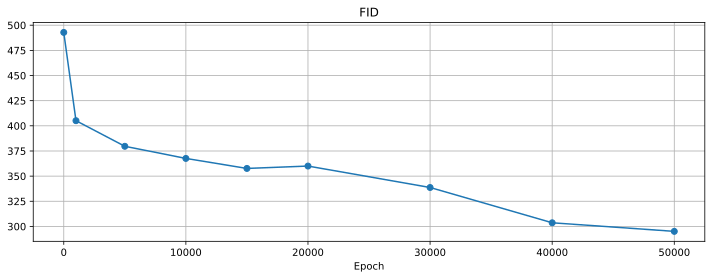

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(checkpoint_idxs, fids, marker='o')
ax.grid(True)

ax.set_xlabel('Epoch')
ax.set_title('FID')

fig.tight_layout()
plt.show()